# HW5: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the white blood cell images into phase/amplitude objects, and then process them through a microscope simulator as we did in HW4, add noise, and then feed the resulting images into a CNN for classification. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the intensity of input illumination incident on the phase/amplitude objects to try to improve classification performance.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will instruct you to use specific values that we have tested and are known to give reasonable results.

Some code adapted from https://www.tensorflow.org/tutorials/quickstart/advanced


## 1. import stuff and load the dataset
As always, we split the dataset into training and testing. You can just run this code, you don't need to understand what's going on

In [1]:
# if this breaks please contact the TAs
#!wget -O data.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
#!unzip /content/data.zip
#!unzip /content/PBC_dataset_normal_DIB > /dev/null

In [2]:
from tensorflow.python.ops.gen_math_ops import sub
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

def load_and_crop(image_path, crop_size, normalized=False):
    image = Image.open(image_path) .resize([256,256])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
cell_types = ['lymphocyte', 'monocyte', 'neutrophil']
cell_inds = np.arange(0, len(cell_types))
x_data = []
y_data = []
for cell_ind in cell_inds:
    all_images = glob.glob(os.path.join('data/PBC_dataset_normal_DIB', cell_types[cell_ind], '*.jpg'))
    x_data += [load_and_crop(image_path, 128) for image_path in all_images]
    y_data += [cell_ind]*len(all_images)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


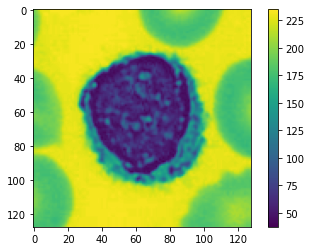

In [3]:
# generating train/val indices
folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.seed(0)
np.random.shuffle(train_indices)

x_data = np.array(x_data)
y_data = np.array(y_data)

x_train = x_data[train_indices]
y_train = np.eye(len(cell_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(cell_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:])
plt.colorbar();

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_test = x_val
y_test = y_val
x_train, x_test = x_train / 255.0, x_test / 255.0  # customary normalization to [0, 1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


## 2. convert the images into microscope samples
Like HW4, we'll just use an image that represents absorption, and then make an approximation to estimate its optical thickness. We will assume that the sample's optical thickness is directly proportional to how much light is absorbed by the sample, allowing you to use the image itself to define both the absorption and phase delay components of the simulated microscope samples. Please convert the images into amplitude/phase objects, assuming that the maximum absorption for a given sample is 1, and the maximum phase delay for each sample is 20 wavelengths. We'll assume the wavelength of the light in this microscope is 500 nm, or 0.5 µm.

In [5]:
wavelength = .5e-3 # units are mm; assuming green light
delta_x = 0.5*wavelength # let's sample at nyquist rate
num_samples = 128

# in real world, microscope samples are 3D and have thickness, which introduce a phase shift to the optical field
# For simplicity, let's further assume the sample thickness and amplitude are inversely correlated, which means the thicker the sample is,
# the more light it absorb.
def convert_images(sample_amplitude):
    sample_phase = 1 - sample_amplitude
    optical_thickness = 20 * wavelength
    return sample_amplitude * np.exp(1j * sample_phase*optical_thickness/wavelength)

x_train = convert_images(x_train)
x_test = convert_images(x_test)

Next, let's generate a new dataset that contains differently illuminated sample images. We will model a plane wave hitting this thin sample like we did for HW4. We will start by modeling 9 different illumination angles for each simulated sample of interest, provided by a 3x3 array of LEDs positioned beneath the sample of interest. Let's assume the center LED is directly beneath the specimen, and that the neighboring LEDs are offset by a 10 degree angle from the center. This will allow us to see how the images change with different illumination angles. Please recall that illumination from a particular angle shifts the sample spectrum across the microscope aperture, causing different components of the shifted spectrum to pass through and onto the detector for different illumination angles. The general process is exactly same as what was considered in HW4. Here, we will model the microscope aperture as a circle, whose effect within this simulation model is to allow only the center pixels of the sample spectrum to pass through the lens and onto the image sensor. Please model and show what the 9 uniquely illuminated images appear like.  

In [6]:
def crop_center(sample, cropx, cropy):
    y,x = sample.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return sample[starty:starty+cropy,startx:startx+cropx]

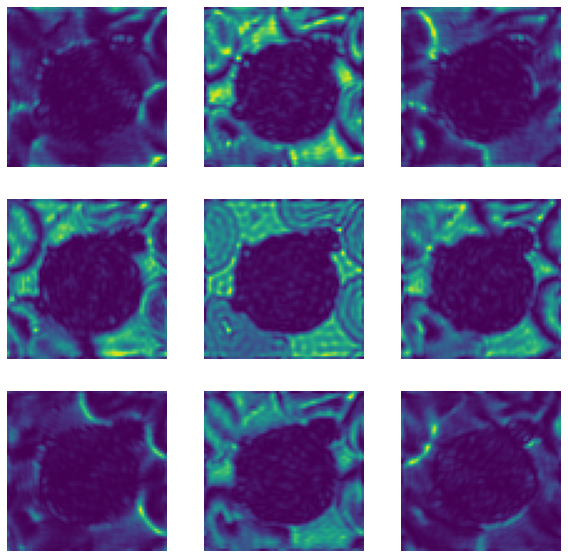

In [7]:
# Define the spatial coordinates of the sample
# code here
starting_coordinate = (-num_samples/2) * delta_x 
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid as needed
# code here
x = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
xx, yy = np.meshgrid(x, y)

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates.
# code here
d = int((ending_coordinate - starting_coordinate) / 4)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1

# define angles
plane_wave_angle_xy = np.array([[0,0], [10,0], [10,10], [0,10], [-10,10], [-10,0], [-10,-10], [0,-10], [10,-10]]) * np.pi/180

# generate illumination dataset
illumination_data = np.zeros((64, 64, 9))
sample = x_test[0]
for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
    # Define plane waves
    # code here
    plane_wave_angle_x = plane_wave_angle[0]
    plane_wave_angle_y = plane_wave_angle[1]
    illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))
    
    # Define field emerging from sample
    # code here
    emerging_field = np.multiply(illumination_plane_wave, sample)
    
    # Take 2D fourier transform of sample
    # code here
    fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

    # Create filtered sample spectrum with center crop (64 x 64)
    # trans: only within desired radius is 1
    # so we can crop the outer part
    # code here
    filtered_sample = np.multiply(fourier_field, trans)
    filtered_sample = crop_center(filtered_sample, 64, 64)
    
    # Propagate filtered sample spectrum to image plane
    # code here
    inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

    # save the intensity of inverse_fourier_field
    # code here
    # Detect intensity (squared magnitude) of resulting field on sensor
    detected_field = np.square(np.abs(inverse_fourier_field))
    illumination_data[:, :, i] = detected_field 

# show absolute^2 value of sample = its intensity
order = [5,6,9,8,7,4,1,2,3]
plt.figure(figsize=(10,10))
for i in range(len(plane_wave_angle_xy)):
    plt.subplot(3, 3, order[i])
    plt.imshow(illumination_data[...,i])
    plt.axis('off')

In [8]:
########################################################################################

Please write a function that returns the 9 illuminated images for each sample as output, given each sample as input. You would mostly reuse the code above.

In [9]:
x_train_illumination = np.zeros((4770,64,64,9))
x_test_illumination = np.zeros((1193,64,64,9))

def return_illumination_data(sample):
    # illumination_data = np.zeros((64, 64, 9))
    # code here
    wavelength = .5e-3 # units are mm; assuming green light
    delta_x = 0.5*wavelength # let's sample at nyquist rate
    num_samples = 128
    
    # Define the spatial coordinates of the sample 
    # code here
    starting_coordinate = (-num_samples/2) * delta_x 
    ending_coordinate = (num_samples/2 - 1) * delta_x
    
    # make linspace, meshgrid as needed
    # code here
    x = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
    y = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
    xx, yy = np.meshgrid(x, y)
    
    # define total range of spatial frequency axis, 1/mm
    # code here
    f_range = int(1 / delta_x)
    delta_fx = f_range / num_samples
    
    # make linspace, meshgrid as needed
    # code here
    starting_coordinate = (-num_samples/2) * delta_fx
    ending_coordinate = (num_samples/2 - 1) * delta_fx
    xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
    yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
    xxf, yyf = np.meshgrid(xf, yf)
    
    # Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
    # Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates.
    # code here
    d = int((ending_coordinate - starting_coordinate) / 4)
    r = d / 2
    
    # Define lens transfer function as matrix with 1's within desired radius, 0's outside
    # code here
    trans = np.zeros((num_samples, num_samples))
    dist = np.sqrt((xxf)**2 + (yyf)**2)
    trans[np.where(dist<r)] = 1
    
    # define angles
    plane_wave_angle_xy = np.array([[0,0], [10,0], [10,10], [0,10], [-10,10], [-10,0], [-10,-10], [0,-10], [10,-10]]) * np.pi/180
    
    # generate illumination dataset
    illumination_data = np.zeros((64, 64, 9))
    
    for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
        # Define plane waves
        # code here
        plane_wave_angle_x = plane_wave_angle[0]
        plane_wave_angle_y = plane_wave_angle[1]
        illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))
        
        # Define field emerging from sample
        # code here
        emerging_field = np.multiply(illumination_plane_wave, sample)
        
        # Take 2D fourier transform of sample
        # code here
        fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))
        
        # Create filtered sample spectrum with center crop (64 x 64)
        # trans: only within desired radius is 1
        # so we can crop the outer part
        # code here
        filtered_sample = np.multiply(fourier_field, trans)
        filtered_sample = crop_center(filtered_sample, 64, 64)
        
        # Propagate filtered sample spectrum to image plane
        # code here
        inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))
        
        # save the intensity of inverse_fourier_field
        # code here
        # Detect intensity (squared magnitude) of resulting field on sensor
        detected_field = np.square(np.abs(inverse_fourier_field))
        illumination_data[:, :, i] = detected_field 
    return illumination_data

for i in range(len(x_train_illumination)):
    x_train_illumination[i] = return_illumination_data(x_train[i])
for i in range(len(x_test_illumination)):
    x_test_illumination[i] = return_illumination_data(x_test[i])

In [10]:
#############################################################################################

## 3. Define variables for physical layer

Next, we will create a trainable matrix (use tf.keras.layers.Conv2D) for the intensity of input illumination. Using this layer, we will compute a weighted sum of images that were filtered by the lens transfer function. Here we will have 9 float values that interact with each sample. Please implement code for the illumination layer (hint: 1*1 convolution) and think carefully about its arguments. In practice, this illumination pattern can be obtained by an led array.

In [11]:
class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train = False, more_exp = False):
        # code here
        super(Illumination, self).__init__()
        self.is_train = is_train
        self.more_exp = more_exp
        self.filter_out = 1 
        self.kernel_size = 1 
        self.strides = 1 

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        # code here
        self.filters_in = input_shape[-1] 
        
        if self.is_train == False :
            if self.more_exp == False : 
                weight_init = tf.constant_initializer(value = float(1 / 9))
            if self.more_exp == True : 
                weight_init = tf.random_normal_initializer(mean = 0, stddev = 0.05)
        
        if self.is_train == True :
            weight_init = tf.random_normal_initializer(mean = 0, stddev = 0.05)
        
        self.kernels = tf.Variable(initial_value=weight_init(shape=(self.kernel_size, 
                                                                    self.kernel_size, 
                                                                    self.filters_in, 
                                                                    self.filter_out)), 
                                   dtype = "float32", trainable = self.is_train)
        
    def call(self, inputs):
        # code here
        out = tf.nn.conv2d(inputs, self.kernels, strides = self.strides, padding = "VALID")
        # print(type(self.kernels))
        return out

## 4. Process the simulated image through a CNN
Use your favorite CNN architecture to classify the resulting captured data, with the simultaneous goal of determining an optimal 3x3 LED pattern. You can copy a network architecture from a model summary below for the classification component (e.g., a 5-layer CNN will be just fine). The key idea is to create and deploy optimization of a physical layer, which computes a weighted sum of the 9 simulated images for each sample, as discussed in class.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [13]:
def cnn_model (is_trainable, more_exp = False) :
    image_size = (64, 64, 9)
    model = Sequential([Input(image_size), 
                        Illumination(is_train = is_trainable, more_exp = more_exp), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Flatten(), Dense(3, activation="softmax")])
    return model

In [14]:
custom_model = cnn_model(is_trainable = False)
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination (Illumination)  (None, 64, 64, 1)        9         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1536)              0

Based on the above model summary, we can see that the 9 parameters in the illumination layer are non-trainable.

## Questions

Ok, now you are ready to run a machine learning model with a physical layer! You did it! To complete the remainder of the homework, please follow the instructions for each question below, and then respond accordingly with the requested information. If it is helpful, please also copy and paste any major code changes into the question response, to help us assess what you did. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters.

1. Using the default hyperparameters based on the instructions and code that we provided, and please run the training under the following conditions:

    a. Allow for the optimization of CNN only (no illumination!). Note that this is a control experiment, because only the CNN is trained, and not the physical layers.
    
    b. Allow for the optimization of the the illumination that illuminates the sample.

    c. Repeat the b. but add noise term which simulates sensor noise before feedind the resulting images into a CNN for classification. 
  
    d. In reality, the brightness of an LED cannot be negative. A simple trick exists to account for this is, by capturing two images (can you think of what that might be?). In any case, it is helpful to also try to constrain the optimized weights to be non-negative. Please try to add this non-negative constraint in from c. (still with the tf.keras.layers.Conv2D - you need to edit the Illumination class) and see if 1) you are able to successfully optimize weights that are non-negative, and 2) how this impacts performance.
    
    For these 4 conditions, report the final test classification accuracies. Also, print the illumination weight and an output image just after the illumination layer for before and after the training. Provide a brief analysis of the results (hint: if you don't see a difference between the above conditions, something probably went wrong!).

## 1 (a)

#### Note for (a)
For the non-trainable illumination layer, after consulting with TAs, I realize there are two ways to initialize the 9 parameters.  
For the first method, I directly set all 9 parameters equal to 1/9 = 0.11111, so the illumination layer just takes the average of 9 simulated images.  
For the second method, I still apply the Gaussian distribution with mean = 0 and standard deviation = 0.05, but the 9 parameters cannot be updated.  
I conducted experiments for both initialization methods below. All results are clearly and completely shown to provide better comparisons.

In [15]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras import layers
tf.get_logger().setLevel("ERROR")

Firstly, I directly set all 9 parameters equal to 1/9 = 0.11111.

In [16]:
custom_model = cnn_model(is_trainable = False, more_exp = False)
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

#### Note for plotting images just after the illumination layer
To provide better comparisons before and after training, I decide to plot the first three images in x_test_illumination instead of plotting only one image. 

In [17]:
def plot_examples (cnnmodel, X) :
    layerout = [layer.output for layer in cnnmodel.layers[0:3]]
    actmodel = models.Model(inputs = cnnmodel.input, outputs = layerout)
    acts = actmodel.predict(X[0:3])
    
    layerout = acts[0]
    
    plt.figure(figsize = (20, 10))
    list_images = [layerout[0,:,:,0], layerout[1,:,:,0], layerout[2,:,:,0]]
    list_columns = len(list_images)
    for i, image in enumerate(list_images) :
        plt.subplot(1, list_columns, i + 1)
        plt.axis("off")
        plt.imshow(image)
    return None

def print_weight (weights) :
    for i in range(weights.shape[2]) :
        print("Weight Number %i" % (i+1), " = %.5f" % weights[0,0,i,0])
    return None

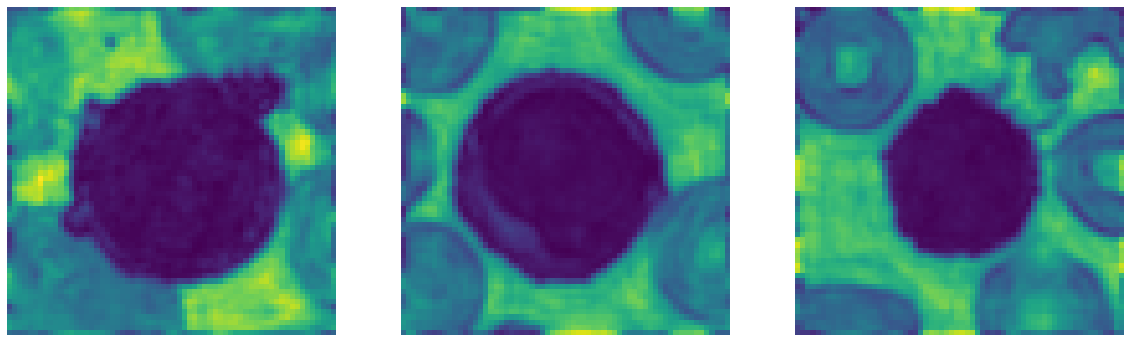

In [18]:
# plot output image just after the illumination layer before training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = custom_model, X = x_test_illumination)

In [19]:
# print illumination weight before training
weights = custom_model.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.11111
Weight Number 2  = 0.11111
Weight Number 3  = 0.11111
Weight Number 4  = 0.11111
Weight Number 5  = 0.11111
Weight Number 6  = 0.11111
Weight Number 7  = 0.11111
Weight Number 8  = 0.11111
Weight Number 9  = 0.11111


In [20]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 4s 26ms/step - loss: 0.3980 - accuracy: 0.8465 - val_loss: 0.2159 - val_accuracy: 0.9271
Epoch 2/10
150/150 [==============================] - 4s 24ms/step - loss: 0.1993 - accuracy: 0.9317 - val_loss: 0.1840 - val_accuracy: 0.9338
Epoch 3/10
150/150 [==============================] - 3s 23ms/step - loss: 0.1646 - accuracy: 0.9457 - val_loss: 0.1796 - val_accuracy: 0.9396
Epoch 4/10
150/150 [==============================] - 3s 22ms/step - loss: 0.1377 - accuracy: 0.9564 - val_loss: 0.1627 - val_accuracy: 0.9438
Epoch 5/10
150/150 [==============================] - 4s 23ms/step - loss: 0.1201 - accuracy: 0.9610 - val_loss: 0.1799 - val_accuracy: 0.9447
Epoch 6/10
150/150 [==============================] - 4s 24ms/step - loss: 0.1023 - accuracy: 0.9654 - val_loss: 0.1502 - val_accuracy: 0.9556
Epoch 7/10
150/150 [==============================] - 3s 23ms/step - loss: 0.0877 - accuracy: 0.9732 - val_loss: 0.1810 - val_accuracy: 0.9497

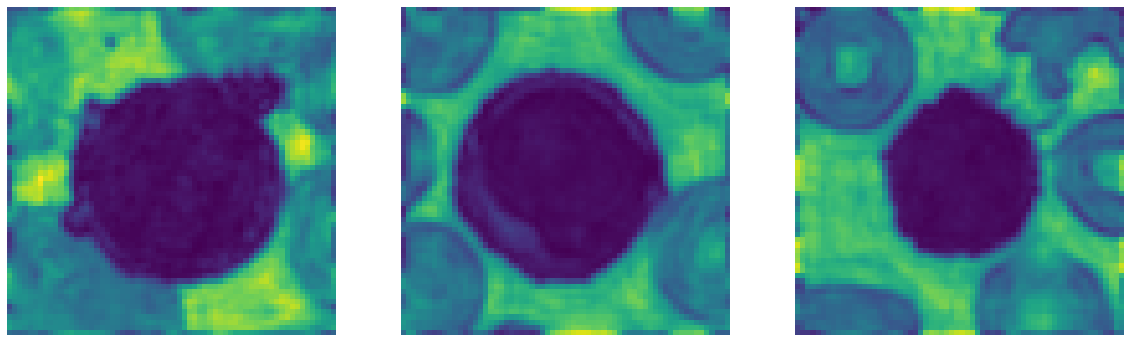

In [21]:
# plot output image just after the illumination layer after training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = custom_model, X = x_test_illumination)

In [22]:
# print illumination weight after training
weights = custom_model.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.11111
Weight Number 2  = 0.11111
Weight Number 3  = 0.11111
Weight Number 4  = 0.11111
Weight Number 5  = 0.11111
Weight Number 6  = 0.11111
Weight Number 7  = 0.11111
Weight Number 8  = 0.11111
Weight Number 9  = 0.11111


In [23]:
#################################################################################

Secondly, I apply Gaussian distribution with mean 0 and standard deviation 0.05 to initialize all 9 parameters.

In [24]:
custom_model = cnn_model(is_trainable = False, more_exp = True)
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

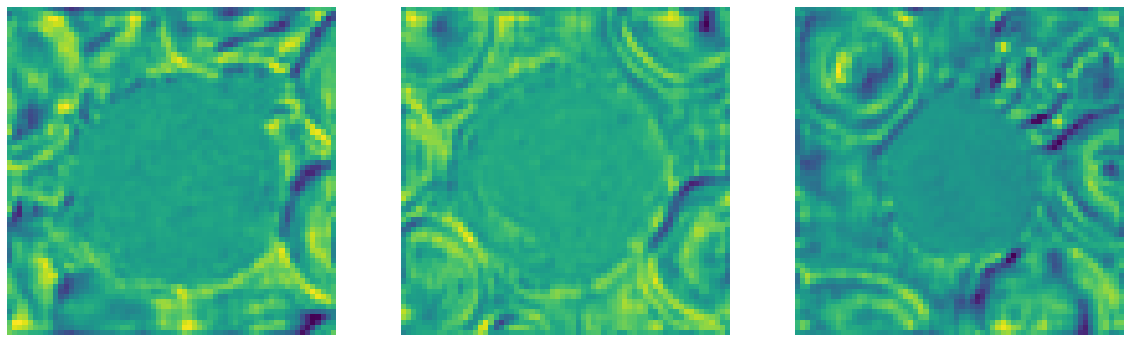

In [25]:
# plot output image just after the illumination layer before training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = custom_model, X = x_test_illumination)

In [26]:
# print illumination weight before training
weights = custom_model.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.07053
Weight Number 2  = 0.07317
Weight Number 3  = -0.02036
Weight Number 4  = -0.03419
Weight Number 5  = 0.06516
Weight Number 6  = -0.06720
Weight Number 7  = -0.05834
Weight Number 8  = -0.02325
Weight Number 9  = -0.00070


In [27]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 4s 25ms/step - loss: 0.4617 - accuracy: 0.8103 - val_loss: 0.2682 - val_accuracy: 0.9011
Epoch 2/10
150/150 [==============================] - 4s 24ms/step - loss: 0.2293 - accuracy: 0.9189 - val_loss: 0.2276 - val_accuracy: 0.9179
Epoch 3/10
150/150 [==============================] - 4s 24ms/step - loss: 0.2017 - accuracy: 0.9247 - val_loss: 0.2120 - val_accuracy: 0.9262
Epoch 4/10
150/150 [==============================] - 4s 24ms/step - loss: 0.1806 - accuracy: 0.9392 - val_loss: 0.2075 - val_accuracy: 0.9271
Epoch 5/10
150/150 [==============================] - 3s 23ms/step - loss: 0.1645 - accuracy: 0.9413 - val_loss: 0.1978 - val_accuracy: 0.9396
Epoch 6/10
150/150 [==============================] - 4s 23ms/step - loss: 0.1404 - accuracy: 0.9514 - val_loss: 0.1951 - val_accuracy: 0.9363
Epoch 7/10
150/150 [==============================] - 3s 23ms/step - loss: 0.1304 - accuracy: 0.9547 - val_loss: 0.2197 - val_accuracy: 0.9321

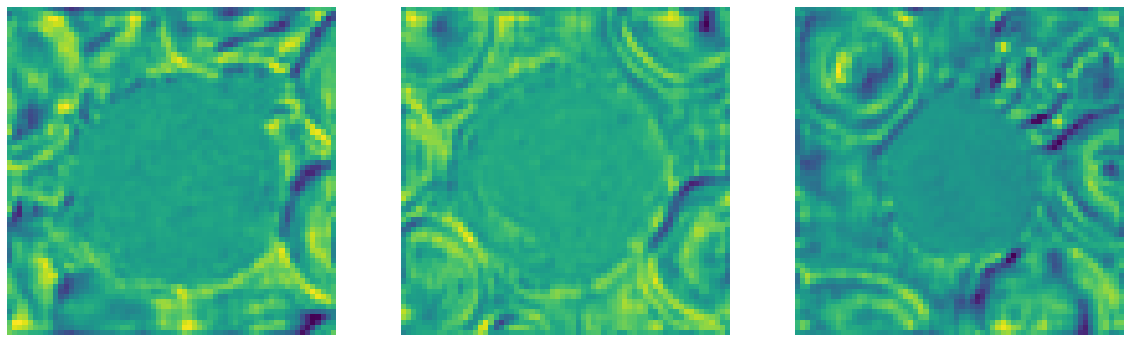

In [28]:
# plot output image just after the illumination layer after training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = custom_model, X = x_test_illumination)

In [29]:
# print illumination weight after training
weights = custom_model.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.07053
Weight Number 2  = 0.07317
Weight Number 3  = -0.02036
Weight Number 4  = -0.03419
Weight Number 5  = 0.06516
Weight Number 6  = -0.06720
Weight Number 7  = -0.05834
Weight Number 8  = -0.02325
Weight Number 9  = -0.00070


### Brief Analysis for 1 (a)
The Final validation accuracy after 10 epochs for the first method is 0.9522.  
The Best validation accuracy after 10 epochs for the first method is 0.9589.  
The Final validation accuracy after 10 epochs for the second method is 0.9430.  
The Best validation accuracy after 10 epochs for the second method is 0.9438.  
For both initialization methods, based on the plotted images and printed weight parameters, we can see that they are exactly the same before and after model training, so we can confirm that the illumination layer is not optimizable here in the control experiment. In specific, I think setting all parameters to 1/9 = 0.11111 is a better initialization method, because this method is clearly more reasonable if we just compute the weighted sum of 9 simulated images for a non-trainable illumination layer. Besides, the reported validation accuracies can also demonstrate my analysis and preference. 

## 1 (b)

In [30]:
model_B = cnn_model(is_trainable = True)
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_3 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                      

Based on the above model summary, we can see that the 9 parameters in the illumination layer now become trainable parameters.

In [31]:
model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

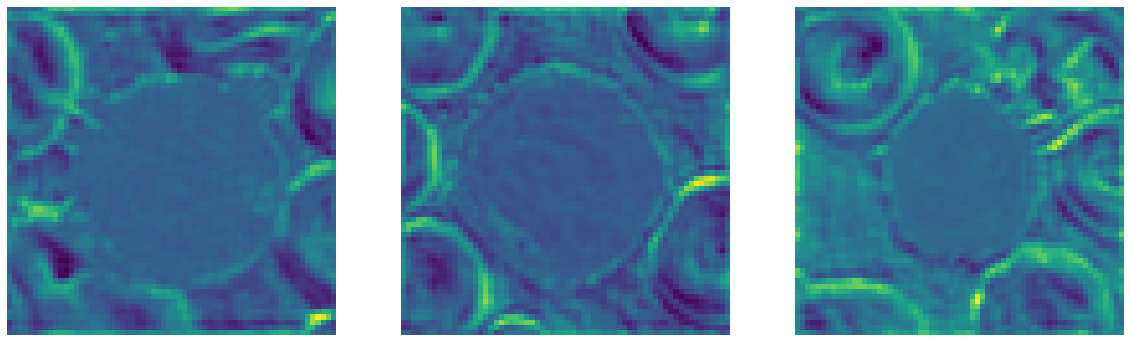

In [32]:
# plot output image just after the illumination layer before training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = model_B, X = x_test_illumination)

In [33]:
# print illumination weight before training
weights = model_B.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = -0.04090
Weight Number 2  = 0.01338
Weight Number 3  = 0.03401
Weight Number 4  = -0.02083
Weight Number 5  = -0.00859
Weight Number 6  = -0.05106
Weight Number 7  = 0.07309
Weight Number 8  = 0.05207
Weight Number 9  = 0.03966


In [34]:
# train model
history = model_B.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 5s 32ms/step - loss: 0.4400 - accuracy: 0.8166 - val_loss: 0.2464 - val_accuracy: 0.9229
Epoch 2/10
150/150 [==============================] - 4s 27ms/step - loss: 0.2248 - accuracy: 0.9210 - val_loss: 0.2586 - val_accuracy: 0.9246
Epoch 3/10
150/150 [==============================] - 4s 27ms/step - loss: 0.1871 - accuracy: 0.9361 - val_loss: 0.1948 - val_accuracy: 0.9413
Epoch 4/10
150/150 [==============================] - 4s 26ms/step - loss: 0.1656 - accuracy: 0.9451 - val_loss: 0.1856 - val_accuracy: 0.9413
Epoch 5/10
150/150 [==============================] - 4s 25ms/step - loss: 0.1487 - accuracy: 0.9470 - val_loss: 0.2013 - val_accuracy: 0.9321
Epoch 6/10
150/150 [==============================] - 4s 26ms/step - loss: 0.1280 - accuracy: 0.9558 - val_loss: 0.1656 - val_accuracy: 0.9472
Epoch 7/10
150/150 [==============================] - 4s 27ms/step - loss: 0.1158 - accuracy: 0.9604 - val_loss: 0.1821 - val_accuracy: 0.9438

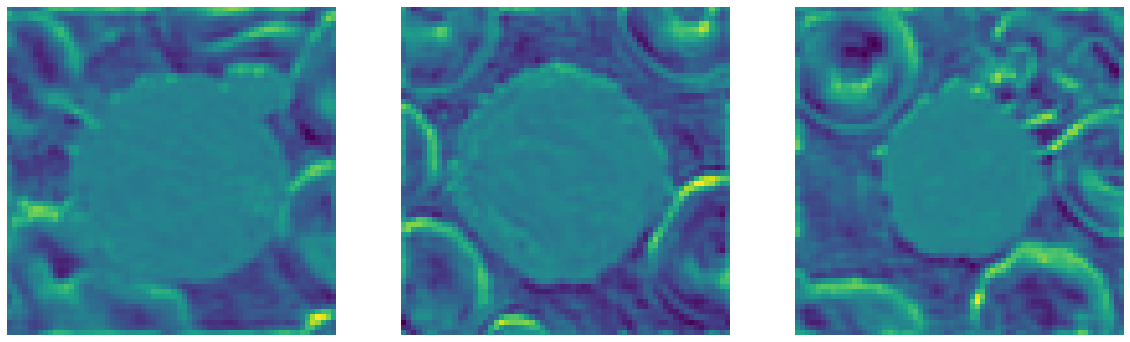

In [35]:
# plot output image just after the illumination layer after training
# Here I plot the first three images in x_test_illumination. 
plot_examples(cnnmodel = model_B, X = x_test_illumination)

In [36]:
# print illumination weight after training
weights = model_B.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = -0.06874
Weight Number 2  = 0.00831
Weight Number 3  = -0.03509
Weight Number 4  = -0.10367
Weight Number 5  = -0.03882
Weight Number 6  = -0.08928
Weight Number 7  = 0.14716
Weight Number 8  = 0.07933
Weight Number 9  = 0.07522


### Brief Analysis for 1 (b)
The Final validation accuracy after 10 epochs is 0.9505.  
The Best validation accuracy after 10 epochs is 0.9505.  
For the optimizable (or trainable) illumination layer, based on the plotted images and printed weight parameters before and after model training, we can see that the 9 weight parameters are indeed different, which demonstrates that the model is optimizing the physical illumination layer during training. We can also see that the plotted images after training have larger contrast between the cell and the background, which further demonstrates that the physical illumination layer is being optimized during training to provide a better combination of weighted sum of 9 simulated/illuminated images. I think this can also be regarded as "optimizable data augmentation", and such augmentation will result in larger contrast between the classification target object (cell) and the background, to help facilitate classification and improve classification performance. We can also see that the best test accuracy (0.9505) for the trainable illumination layer indeed increases a bit compared with the best test accuracy (0.9438) for the non-trainable illumination layer with the second (Gaussian distribution) initialization method, which helps demonstrate my analysis.

## 1 (c)
hint: tf.keras.layers.GaussianNoise(0.05)

In [37]:
from tensorflow.keras.layers import GaussianNoise
tf.get_logger().setLevel("ERROR")

In [38]:
def model_noise (is_trainable) :
    image_size = (64, 64, 9)
    model = Sequential([Input(image_size), 
                        Illumination(is_train = is_trainable), 
                        # Add Gaussian Noise to the images before feeding into a CNN for classification
                        GaussianNoise(0.05), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Flatten(), Dense(3, activation="softmax")])
    return model

In [39]:
model_C = model_noise(is_trainable = True)
model_C.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_4 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 gaussian_noise (GaussianNoi  (None, 64, 64, 1)        0         
 se)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 6)         906       
                                                      

Based on the above model summary, we can see that the Gaussian Noise Layer has been added to the CNN model.

In [40]:
model_C.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy'])

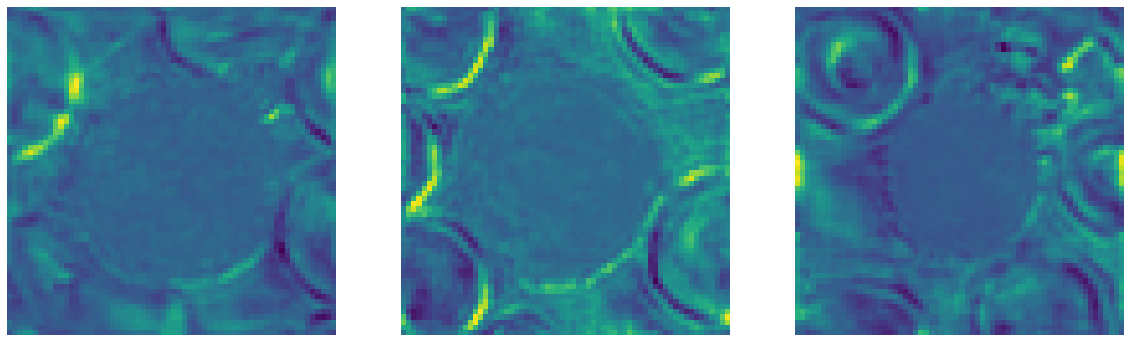

In [41]:
# plot output image just after the illumination layer before training
# Here I plot the first three images in x_test_illumination. 
plot_examples(model_C, x_test_illumination)

In [42]:
# print illumination weight before training
weights = model_C.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = -0.00373
Weight Number 2  = -0.02426
Weight Number 3  = 0.08152
Weight Number 4  = 0.01604
Weight Number 5  = -0.04725
Weight Number 6  = 0.04840
Weight Number 7  = -0.02068
Weight Number 8  = -0.03776
Weight Number 9  = 0.03164


In [43]:
# train model
history = model_C.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 5s 31ms/step - loss: 0.4782 - accuracy: 0.7962 - val_loss: 0.2417 - val_accuracy: 0.9195
Epoch 2/10
150/150 [==============================] - 4s 28ms/step - loss: 0.2193 - accuracy: 0.9258 - val_loss: 0.1887 - val_accuracy: 0.9388
Epoch 3/10
150/150 [==============================] - 4s 28ms/step - loss: 0.1766 - accuracy: 0.9384 - val_loss: 0.1657 - val_accuracy: 0.9497
Epoch 4/10
150/150 [==============================] - 4s 29ms/step - loss: 0.1471 - accuracy: 0.9488 - val_loss: 0.1460 - val_accuracy: 0.9455
Epoch 5/10
150/150 [==============================] - 4s 29ms/step - loss: 0.1366 - accuracy: 0.9551 - val_loss: 0.1700 - val_accuracy: 0.9338
Epoch 6/10
150/150 [==============================] - 4s 27ms/step - loss: 0.1209 - accuracy: 0.9562 - val_loss: 0.1426 - val_accuracy: 0.9539
Epoch 7/10
150/150 [==============================] - 4s 26ms/step - loss: 0.1051 - accuracy: 0.9627 - val_loss: 0.1695 - val_accuracy: 0.9396

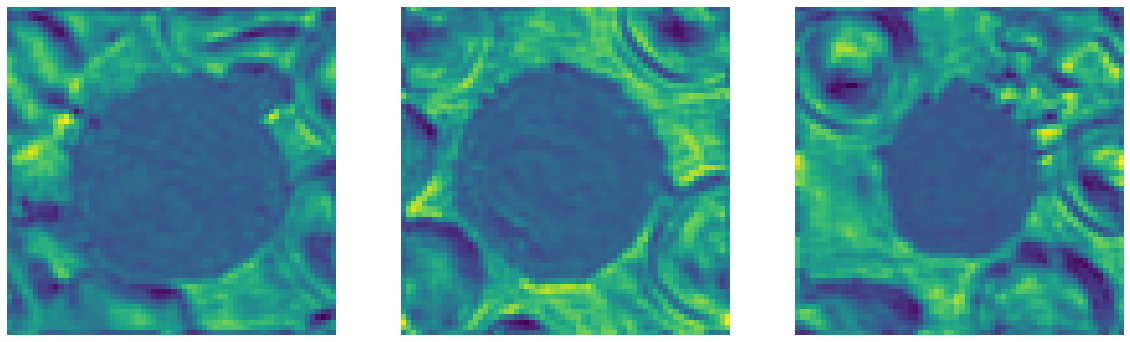

In [44]:
# plot output image just after the illumination layer after training
# Here I plot the first three images in x_test_illumination. 
plot_examples(model_C, x_test_illumination)

In [45]:
# print illumination weight after training
weights = model_C.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.01476
Weight Number 2  = -0.01998
Weight Number 3  = 0.12769
Weight Number 4  = 0.13160
Weight Number 5  = -0.02751
Weight Number 6  = 0.12716
Weight Number 7  = -0.02555
Weight Number 8  = -0.10458
Weight Number 9  = -0.03528


### Brief Analysis for 1 (c)
The Final validation accuracy after 10 epochs is 0.9539.  
The Best validation accuracy after 10 epochs is 0.9539.  
Based on the plotted images and printed weight parameters before and after model training, we can see that the 9 weight parameters are indeed different, which demonstrates that the model is optimizing the physical illumination layer during training. We can also see that the plotted images after training have larger contrast between the cell and the background. Here in 1(c), we also add Gaussian noise to the resulting images, and adding Gaussian noise can be regarded as a data augmentation technique. Therefore, with larger image contrast brought by the trainable illumination layer, and the following data augmentation by adding Gaussian noise, we can achieve a better test accuracy (0.9539) in 1(c), compared with the test accuracy (0.9505) achieved in 1(b).

## 1 (d)

### Note for 1 (d)
To implement the non-negative constraint, I know how to complete the "NonNegative" object as shown below, but I also find another good way, which is to add non-negative constraint to tf.Variable. After consulting with TAs, the TA expressed his concern that adding constraint in the "build" method may not obtain all non-negative parameters after training. However, after trying different learning rates (small & large) and different epochs (small & large), I can obtain all 9 trainable parameters as non-negative numbers all the time.  
Therefore, I think my implementation for adding non-negative constraint can be appropriate and solid. Thanks very much for your understanding.

In [55]:
class NonNegative(tf.keras.constraints.Constraint):
    def call(self, w):
        # code here
        adj_w = w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)
        return adj_w

class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train = False):
        # code here
        super(Illumination, self).__init__()
        self.is_train = is_train
        self.filter_out = 1 
        self.kernel_size = 1 
        self.strides = 1 

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        # code here
        self.filters_in = input_shape[-1] 
        
        if self.is_train == False :
            weight_init = tf.constant_initializer(value = float(1 / 9)) 
        if self.is_train == True :
            weight_init = tf.random_normal_initializer(mean = 0, stddev = 0.05)
        
        self.kernels = tf.Variable(initial_value=weight_init(shape=(self.kernel_size, 
                                                                    self.kernel_size, 
                                                                    self.filters_in, 
                                                                    self.filter_out)), 
                                   dtype = "float32", 
                                   trainable = self.is_train, 
                                   constraint = lambda w: tf.clip_by_value(w, 
                                                                           clip_value_min = 0, 
                                                                           clip_value_max = np.infty))
    
    def call(self, inputs):
        # code here
        out = tf.nn.conv2d(inputs, self.kernels, strides = self.strides, padding = "VALID")
        return out

In [56]:
def model_noise (is_trainable) :
    image_size = (64, 64, 9)
    model = Sequential([Input(image_size), 
                        Illumination(is_train = is_trainable), 
                        GaussianNoise(0.05), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Conv2D(filters=6, kernel_size=5, strides=1, padding="same", activation="relu"), 
                        MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
                        Flatten(), Dense(3, activation="softmax")])
    return model

In [57]:
model_D = model_noise(is_trainable = True)
model_D.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_6 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 gaussian_noise_2 (GaussianN  (None, 64, 64, 1)        0         
 oise)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 6)         906       
                                                      

In [58]:
model_D.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

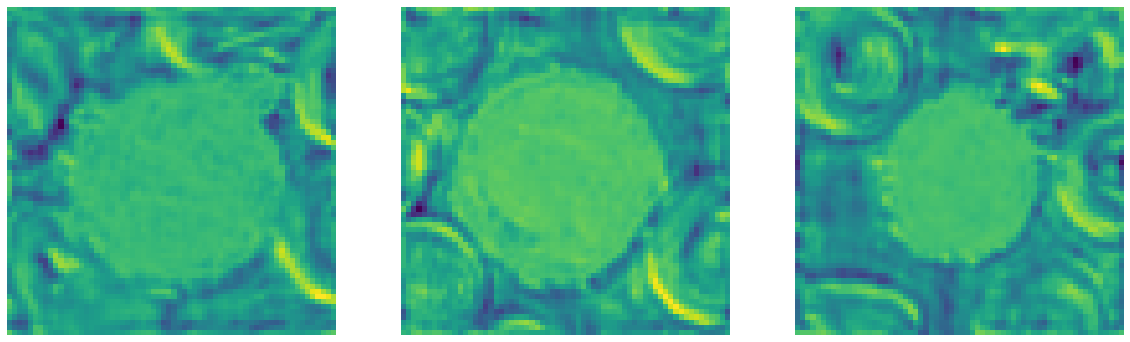

In [59]:
# plot output image just after the illumination layer before training
# Here I plot the first three images in x_test_illumination. 
plot_examples(model_D, x_test_illumination)

In [60]:
# print illumination weight before training
weights = model_D.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = -0.05192
Weight Number 2  = -0.07554
Weight Number 3  = -0.05124
Weight Number 4  = 0.04724
Weight Number 5  = 0.02707
Weight Number 6  = 0.00285
Weight Number 7  = -0.03117
Weight Number 8  = 0.02747
Weight Number 9  = 0.01855


### Note
The non-negative constraint applied to 9 trainable illumination layer parameters (tf.Variable) will be activated and updated by an Optimizer during model training. Therefore, before training, we can see some negative weights because these parameters are initialized by the Gaussian distribution with mean value equal to 0 and standard deviation equal to 0.05.

In [61]:
# train model
history = model_D.fit(x_train_illumination, y_train, epochs=15, validation_data=(x_test_illumination, y_test))

Epoch 1/15
150/150 [==============================] - 4s 28ms/step - loss: 0.5047 - accuracy: 0.7832 - val_loss: 0.2388 - val_accuracy: 0.9237
Epoch 2/15
150/150 [==============================] - 4s 27ms/step - loss: 0.2475 - accuracy: 0.9178 - val_loss: 0.2009 - val_accuracy: 0.9388
Epoch 3/15
150/150 [==============================] - 4s 28ms/step - loss: 0.1968 - accuracy: 0.9348 - val_loss: 0.1638 - val_accuracy: 0.9531
Epoch 4/15
150/150 [==============================] - 4s 28ms/step - loss: 0.1496 - accuracy: 0.9484 - val_loss: 0.1368 - val_accuracy: 0.9589
Epoch 5/15
150/150 [==============================] - 4s 26ms/step - loss: 0.1228 - accuracy: 0.9585 - val_loss: 0.1363 - val_accuracy: 0.9556
Epoch 6/15
150/150 [==============================] - 4s 27ms/step - loss: 0.1054 - accuracy: 0.9646 - val_loss: 0.1477 - val_accuracy: 0.9514
Epoch 7/15
150/150 [==============================] - 4s 26ms/step - loss: 0.1019 - accuracy: 0.9686 - val_loss: 0.1599 - val_accuracy: 0.9514

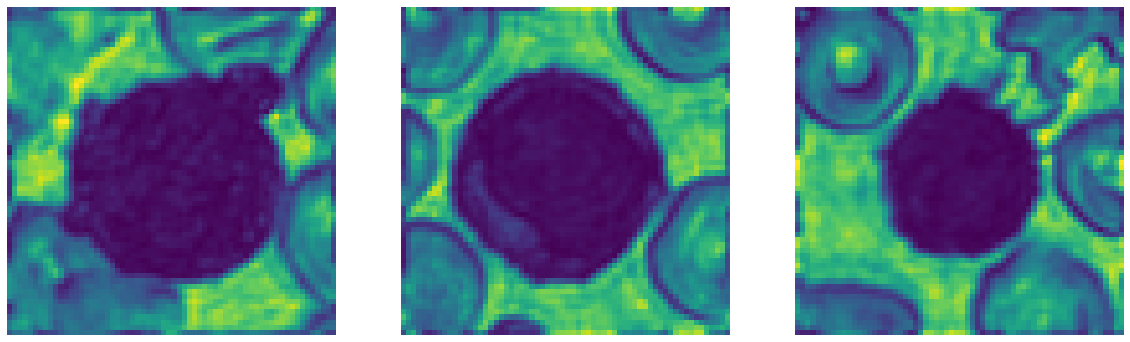

In [62]:
# plot output image just after the illumination layer after training
# Here I plot the first three images in x_test_illumination. 
plot_examples(model_D, x_test_illumination)

In [63]:
# print illumination weight after training
weights = model_D.layers[0].get_weights()
print_weight(weights[0])

Weight Number 1  = 0.10339
Weight Number 2  = 0.09914
Weight Number 3  = 0.09577
Weight Number 4  = 0.15961
Weight Number 5  = 0.00209
Weight Number 6  = 0.00133
Weight Number 7  = 0.00117
Weight Number 8  = 0.00549
Weight Number 9  = 0.02032


### Note
After training, we can see that all 9 illumination weight parameters are non-negative.  
This demonstrates that I am able to successfully optimize illumination weights that are non-negative.

### Brief Analysis for 1 (d)
The Final validation accuracy after 15 epochs is 0.9405.  
The Best validation accuracy after 15 epochs is 0.9606.  
Firstly, for the non-negative constraint, based on the printed weight parameters before and after model training, it can be demonstrated that I am able to successfully optimize illumination weights that are non-negative.  
Secondly, for the classification performance, the best test accuracy (0.9606) achieved in 1(d) is actually the highest accuracy achieved in all four questions, so I think applying the non-negative constraint to illumination weights can help improve classification performance.  
Thirdly, based on the plotted images after training, we can see that they are kind of similar to the plotted images when I set all 9 illumination weights equal to 1/9 = 0.11111. We can also see that images after training have larger contrast between the cell and the background, compared with images before training. I think these facts can further demonstrate that I can successfully optimize illumination weights with non-negative constraint.